fun trick to get imports to work properly

In [3]:
import sys
sys.path.insert(0, '..')

In [4]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import numpy

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

# the real world
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astrocut import fits_cut
from astropy.nddata import Cutout2D

import pandas as pd

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

data loading

In [5]:
ddir = '../data/MAST_2024-07-03T0023-1/'

fname = ddir + 'HST/n9nk01010/n9nk01010_mos.fits'
#fname = ddir + 'HST/n8yj02010/n8yj02010_mos.fits'
#fname = ddir + 'HST/n9nk14010/n9nk14010_mos.fits'

#fname = ddir + 'HST/n9nk01020/n9nk01020_mos.fits'
#fname = ddir + 'HST/n9nk14020/n9nk14020_mos.fits'
#fname = ddir + 'HST/n8yj65020/n8yj65020_mos.fits'


#dir = '../data/MAST_2024-07-07T03_17_36.223Z/'
#fname = ddir + 'HST/n8ku01050_mos.fits'

ddir = '../data/MAST_2024-07-11T09_26_05.575Z/'
fname = ddir + 'HST/N43CA5020/n43ca5020_mos.fits'

wid = 64

exposure = exposure_from_file(fname, wid)


f170m = np.asarray(pd.read_csv("../data/HST_NICMOS1.F170M.dat", sep=' '))
f095n = np.asarray(pd.read_csv("../data/HST_NICMOS1.F095N.dat", sep=' '))
f145m = np.asarray(pd.read_csv("../data/HST_NICMOS1.F145M.dat", sep=' '))


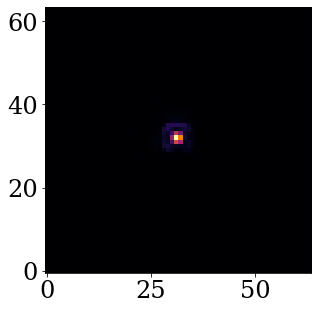

In [6]:
plt.imshow(exposure.data)

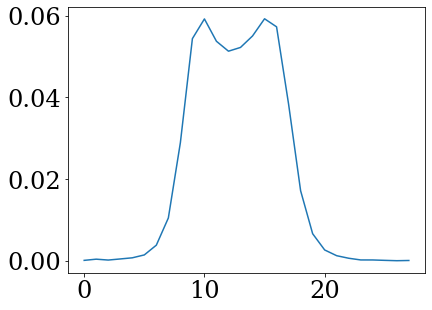

In [7]:
plt.plot(f095n[::5,1])

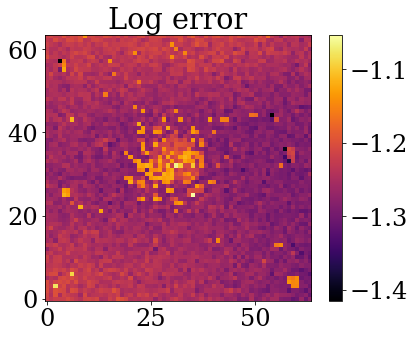

In [8]:
plt.imshow(np.log10(exposure.err))
plt.title("Log error")
plt.colorbar()

construct model

In [9]:
# F170M

#wavels = 1e-6 * np.linspace(1.60, 1.80, 20)

# F110W
#wavels = 1e-6 * np.linspace(0.8, 1.35, 40)

#weights = np.concatenate([np.linspace(0., 1., 10), np.linspace(1., 0., 10)])

#wavels = f170m[::25,0]/1e10
#weights = f170m[::25,1]

wavels = f095n[::5,0]/1e10
weights = f095n[::5,1]


temp = 3210 #check this

c=3e8
h = 6.626e-34
kb = 1.38e-23

f = c/wavels

# blackbody calculation
B = 2*h*c/(wavels**3) * 1/(np.exp(h*f/(kb*temp))-1)

b_weights = weights*B/np.max(B)

source = dl.PointSource(
    #wavelengths=wavels,
    spectrum=dl.Spectrum(wavels, weights),
    flux = 5000,
    #position = np.asarray([-5e-7,5e-7])
)

source = dl.BinarySource(
    #position = np.asarray([-5e-7,5e-7]),
    wavelengths=wavels,
    weights=weights,
    spectrum=dl.Spectrum(wavels, weights),
    mean_flux=3000,
    separation=dlu.arcsec2rad(0.042),
    position_angle=1.8607855,
    contrast = 0.3,
)

oversample = 3

optics = dl.AngularOpticalSystem(
    512,
    2.4,
    [
        dl.CompoundAperture([
            ("main_aperture",HSTMainAperture(transformation=dl.CoordTransform(rotation=np.pi/4),softening=0.1)),
            ("cold_mask",NICMOSColdMask(transformation=dl.CoordTransform(translation=np.asarray((-0.05,-0.05)),rotation=np.pi/4), softening=0.1))
        ],normalise=True),
        dl.AberratedAperture(
            dl.layers.CircularAperture(1.2),
            noll_inds=np.asarray([4,5,6,7,8,9,10,11]),#,12,13,14,15,16,17,18,19,20]),
            coefficients = np.asarray([0,18,19.4,-1.4,-3,3.3,1.7,-12.2])*1e-9#,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])*1e-9
        )
    ],
    wid,
    0.0432,
    oversample
)

detector = dl.LayeredDetector(
    [
        ("detector_response", ApplyNonlinearity(coefficients=np.zeros(1), order = 3)),
        ("constant", dl.layers.AddConstant(value=0.0)),
        ("pixel_response",dl.layers.ApplyPixelResponse(np.ones((wid*oversample,wid*oversample)))),
        #("jitter", dl.layers.ApplyJitter(sigma=0.1)),
        ("downsample", dl.layers.Downsample(oversample))
     ]
)


telescope = dl.Telescope(
    optics,
    source,
    detector
)

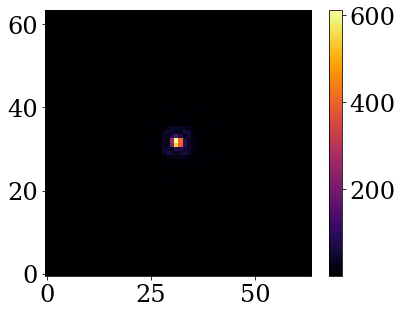

In [10]:
plt.imshow(telescope.model())
plt.colorbar()

gradient time

In [26]:

# need a better name for this

def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]

things = {
    "mean_flux" : opt(3e-3, 10),
    "position": opt(1e-23, 0),
    "separation": opt(1e-22, 30),
    "contrast": opt(1e-7, 30),
    "position_angle": opt(4e-8, 20),
    #"cold_mask.transformation.translation": opt(1e-13, 50),
    #"cold_mask.transformation.rotation": opt(1e-12, 50),
    "AberratedAperture.coefficients": opt(0.5e-23, 40),
    #(
    #    "cold_mask.outer.radius",
    #    "cold_mask.secondary.radius"
    #) : opt(5e-13, 50),
    #"cold_mask.spider.width": opt(1e-13, 50),
    #"main_aperture.spider.width": opt(0e-3),
    #"cold_mask.softening" : opt(0e-3),
    "constant.value" : opt(1e-9, 40),
    #"detector_response.coefficients" : opt(0e-10),
    #"optics.psf_pixel_scale" : opt(0e-10),

}

g = 2e-2

things = {
    #"flux": opt(g*1e0, 20),

    "mean_flux" : opt(g*10,10),
    "position": opt(g*1, 0),
    "separation": opt(g*1, 20),
    "contrast": opt(g*1, 20),
    "position_angle": opt(g*1, 20),
    "cold_mask.transformation.translation": opt(g*100,100),
    "cold_mask.transformation.rotation": opt(g*100,100),
    "AberratedAperture.coefficients": opt(g*1,50),
    "cold_mask.outer.radius": opt(g*10, 130),
    "cold_mask.secondary.radius": opt(g*10,130),
    "cold_mask.spider.width": opt(g*10,130),
    #"main_aperture.spider.width": opt(0e-3),
    #"cold_mask.softening" : opt(0e-3),
    #"constant.value" : opt(g*1e0,10),
    #"detector_response.coefficients" : opt(0e-10),
    #"optics.psf_pixel_scale" : opt(0e-10),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [27]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths)
def loss_fn(model,exposure):
    return posterior(model,exposure)

In [28]:
array_model = zdx.set_array(telescope,paths)

fishers = calc_fishers(array_model, [exposure], paths, recalculate=True)
lrs = calc_lrs(array_model, [exposure], fishers, paths)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[[30.453754]]
[[ 3.7067454e+21 -1.1483472e+20]
 [-1.1483454e+20  3.9811230e+21]]
[[8.360066e+20]]
[[58763876.]]
[[20217662.]]
[[-5.3386484e+11  4.0203076e+11]
 [ 4.0203082e+11 -5.1899518e+11]]
[[-5.4370127e+11]]
[[-1.3100560e+21  1.7569093e+20  4.8213145e+20  8.5595541e+20
   5.9187123e+20 -5.5274842e+19 -1.7380570e+20 -6.3630721e+19]
 [ 1.7569547e+20 -2.4656155e+21 -1.8357721e+20  7.2605028e+20
   4.8553966e+20  4.1262754e+20 -3.8641873e+20  1.5648540e+20]
 [ 4.8213346e+20 -1.8357360e+20 -2.4170909e+21 -9.8491929e+20
   3.8712087e+20  3.4577843e+20  2.6905500e+20  1.0554373e+20]
 [ 8.5595597e+20  7.2604655e+20 -9.8490635e+20  4.5201518e+20
  -1.9715660e+20  5.2110701e+20  2.2679966e+20  4.6258657e+20]
 [ 5.9187488e+20  4.8555032e+20  3.8712225e+20 -1.9715994e+20
   8.8735634e+20 -1.6785143e+20 -3.0267849e+20  2.9686962e+20]
 [-5.5274235e+19  4.1263063e+20  3.4578349e+20  5.2110708e+20
  -1.6784860e+20  8.9461818e+20 -2.5675625e+20 -2.7878759e+19]
 [-1.7380709e+20 -3.8642018e+20  2.690

In [29]:
lrs.get(paths)

[Array(-0.03283668, dtype=float32),
 Array([-2.6977844e-22, -2.5118540e-22], dtype=float32),
 Array(-1.1961628e-21, dtype=float32),
 Array(-1.7017257e-08, dtype=float32),
 Array(-4.9461704e-08, dtype=float32),
 Array([1.8731334e-12, 1.9268001e-12], dtype=float32),
 Array(1.8392453e-12, dtype=float32),
 Array([ 7.6332615e-22,  4.0557823e-22,  4.1372046e-22, -2.2123151e-21,
        -1.1269430e-21, -1.1177953e-21, -1.1974824e-21,  1.2700952e-21],      dtype=float32),
 Array(5.684265e-12, dtype=float32),
 Array(1.1789566e-11, dtype=float32),
 Array(5.349123e-12, dtype=float32)]

le optimisation

In [30]:
pixel_opt = optax.piecewise_constant_schedule(init_value=1e-4*1e-8, 
                             boundaries_and_scales={100 : int(1e8)})


optim, opt_state = zdx.get_optimiser(
    telescope, groups, optimisers
)



losses, models = [], []
for i in tqdm(range(200)):
    loss, grads = loss_fn(telescope,exposure)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, lrs)
    updates, opt_state = optim.update(grads, opt_state)
    telescope = zdx.apply_updates(telescope, updates)

    models.append(telescope)
    losses.append(loss)


  0%|          | 0/200 [00:00<?, ?it/s]

1.800754e+07, 7.168686e+05
mean_flux 3159.5042
position [-4.384352e-09  7.010001e-08]
separation 1.9660746e-07
contrast 0.18589722
position_angle 2.0419052
cold_mask.transformation.translation [-0.05121734 -0.05121287]
cold_mask.transformation.rotation 0.7845622
AberratedAperture.coefficients [ 1.1613718e-08  1.0759088e-08 -8.0927460e-09 -3.7371983e-08
  1.8933834e-08  1.0776950e-08 -3.2799472e-09  1.0416883e-09]
cold_mask.outer.radius 1.1452235
cold_mask.secondary.radius 0.44631308
cold_mask.spider.width 0.09230433


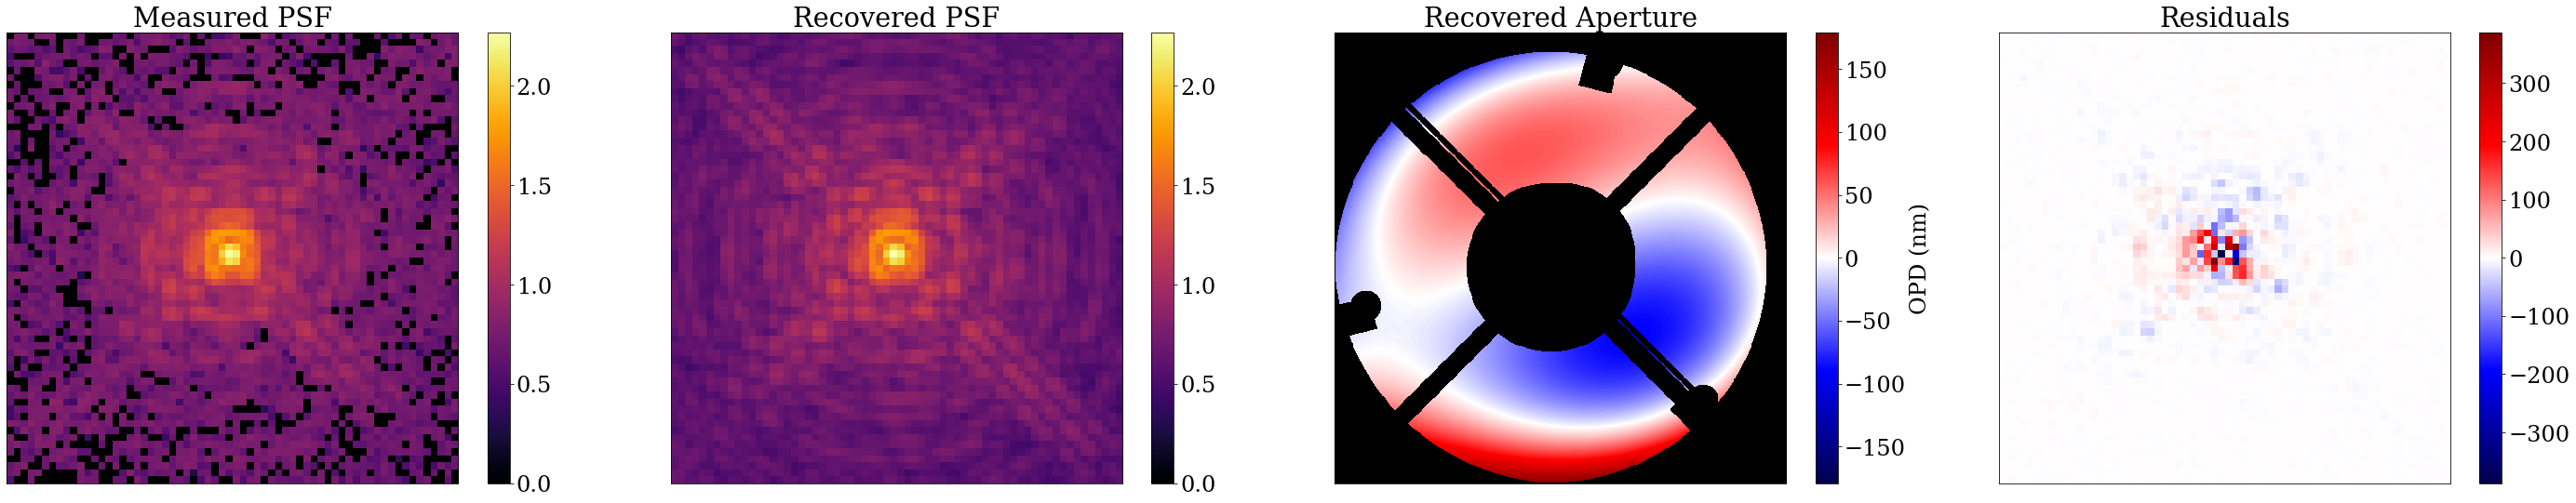

In [ ]:
print(f"{float(losses[0]):e}, {float(losses[-1]):e}")

#print(telescope.get(paths))

for g in groups:
    if type(g) == list:
        for s in g:
            print(s, telescope.get(s))
    else:
        print(g, telescope.get(g))

#plt.figure(figsize=(10, 4))


fig, axs = plt.subplots(1,4, figsize=(40,8))

fig.tight_layout()

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

#vm = max(np.max(cropped_data),np.max(telescope.model()))

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exposure.data**0.125
telescope_frame = telescope.model()**0.125

vm = max(np.nanmax(cropped_frame),np.nanmax(telescope_frame))
cd=axs[0].imshow(cropped_frame, vmin=0,vmax=vm,cmap=cmap)
plt.colorbar(cd,ax=axs[0])
tl=axs[1].imshow(telescope_frame, vmin=0, vmax=vm,cmap=cmap)
plt.colorbar(tl,ax=axs[1])
#axs[2].imshow(cropped_err)
cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)
support = telescope.optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd = telescope.optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd))
apt =axs[2].imshow(support_mask*opd,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("OPD (nm)")
#axs[4].imshow(telescope.detector.pixel_response.pixel_response)
resid = (exposure.data - telescope.model())/exposure.err
rlim = np.nanmax(np.abs(resid))
resid=axs[3].imshow(resid, cmap='seismic',vmin=-rlim, vmax=rlim)
plt.colorbar(resid,ax=axs[3])

axs[0].set_title("Measured PSF")
axs[1].set_title("Recovered PSF")
axs[2].set_title("Recovered Aperture")
axs[3].set_title("Residuals")

for i in range(4):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

#axs[1].imshow(telescope.optics.aberrations.eval_basis(coords)*1e9)
plt.show()
#plt.imshow(np.abs(telescope.model()-cropped_data)**0.25)


[Array(18007542., dtype=float32), Array(16902102., dtype=float32), Array(15631998., dtype=float32), Array(14328290., dtype=float32), Array(13066307., dtype=float32), Array(11886375., dtype=float32), Array(10807414., dtype=float32), Array(9835519., dtype=float32), Array(8969329., dtype=float32), Array(8203348., dtype=float32), Array(7529957., dtype=float32), Array(6773375.5, dtype=float32), Array(6269116., dtype=float32), Array(5879817.5, dtype=float32), Array(5543684., dtype=float32), Array(5242687., dtype=float32), Array(4974315.5, dtype=float32), Array(4738032., dtype=float32), Array(4531760.5, dtype=float32), Array(4352266., dtype=float32), Array(4196141., dtype=float32), Array(3936541.2, dtype=float32), Array(3730083.8, dtype=float32), Array(3568792.5, dtype=float32), Array(3444513.5, dtype=float32), Array(3349733., dtype=float32), Array(3277961.5, dtype=float32), Array(3223823.8, dtype=float32), Array(3183012.5, dtype=float32), Array(3152162.5, dtype=float32), Array(3128693.2, dty

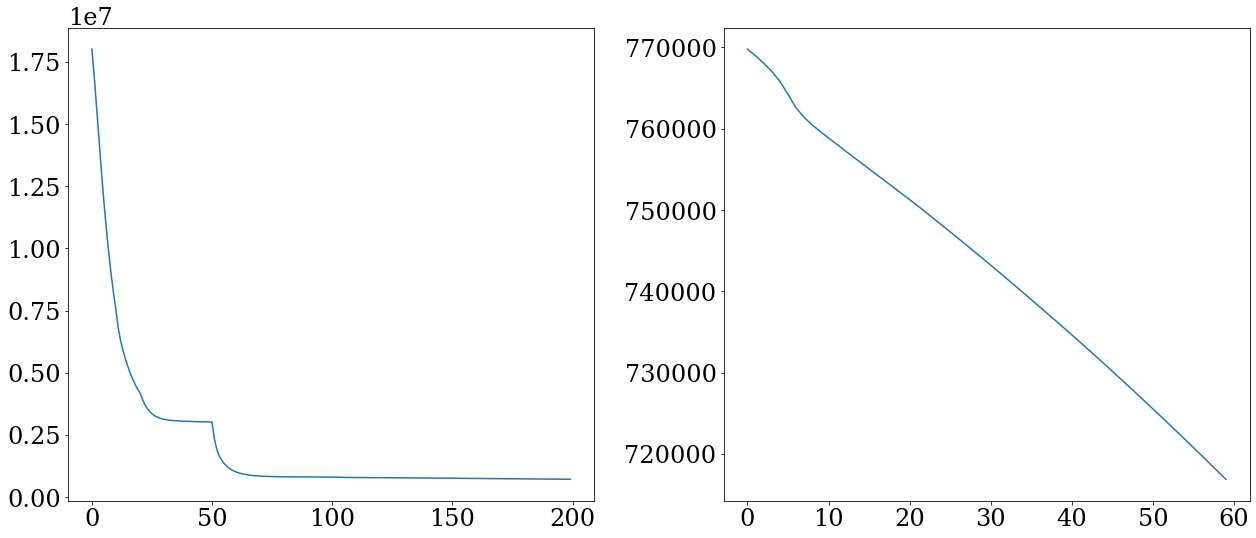

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(18,8))
axs[0].plot(losses)
axs[1].plot(losses[-60:])
fig.tight_layout()
print(losses)

11
mean_flux
position
separation
contrast
position_angle
cold_mask.transformation.translation
cold_mask.transformation.rotation
AberratedAperture.coefficients
cold_mask.outer.radius
cold_mask.secondary.radius
cold_mask.spider.width


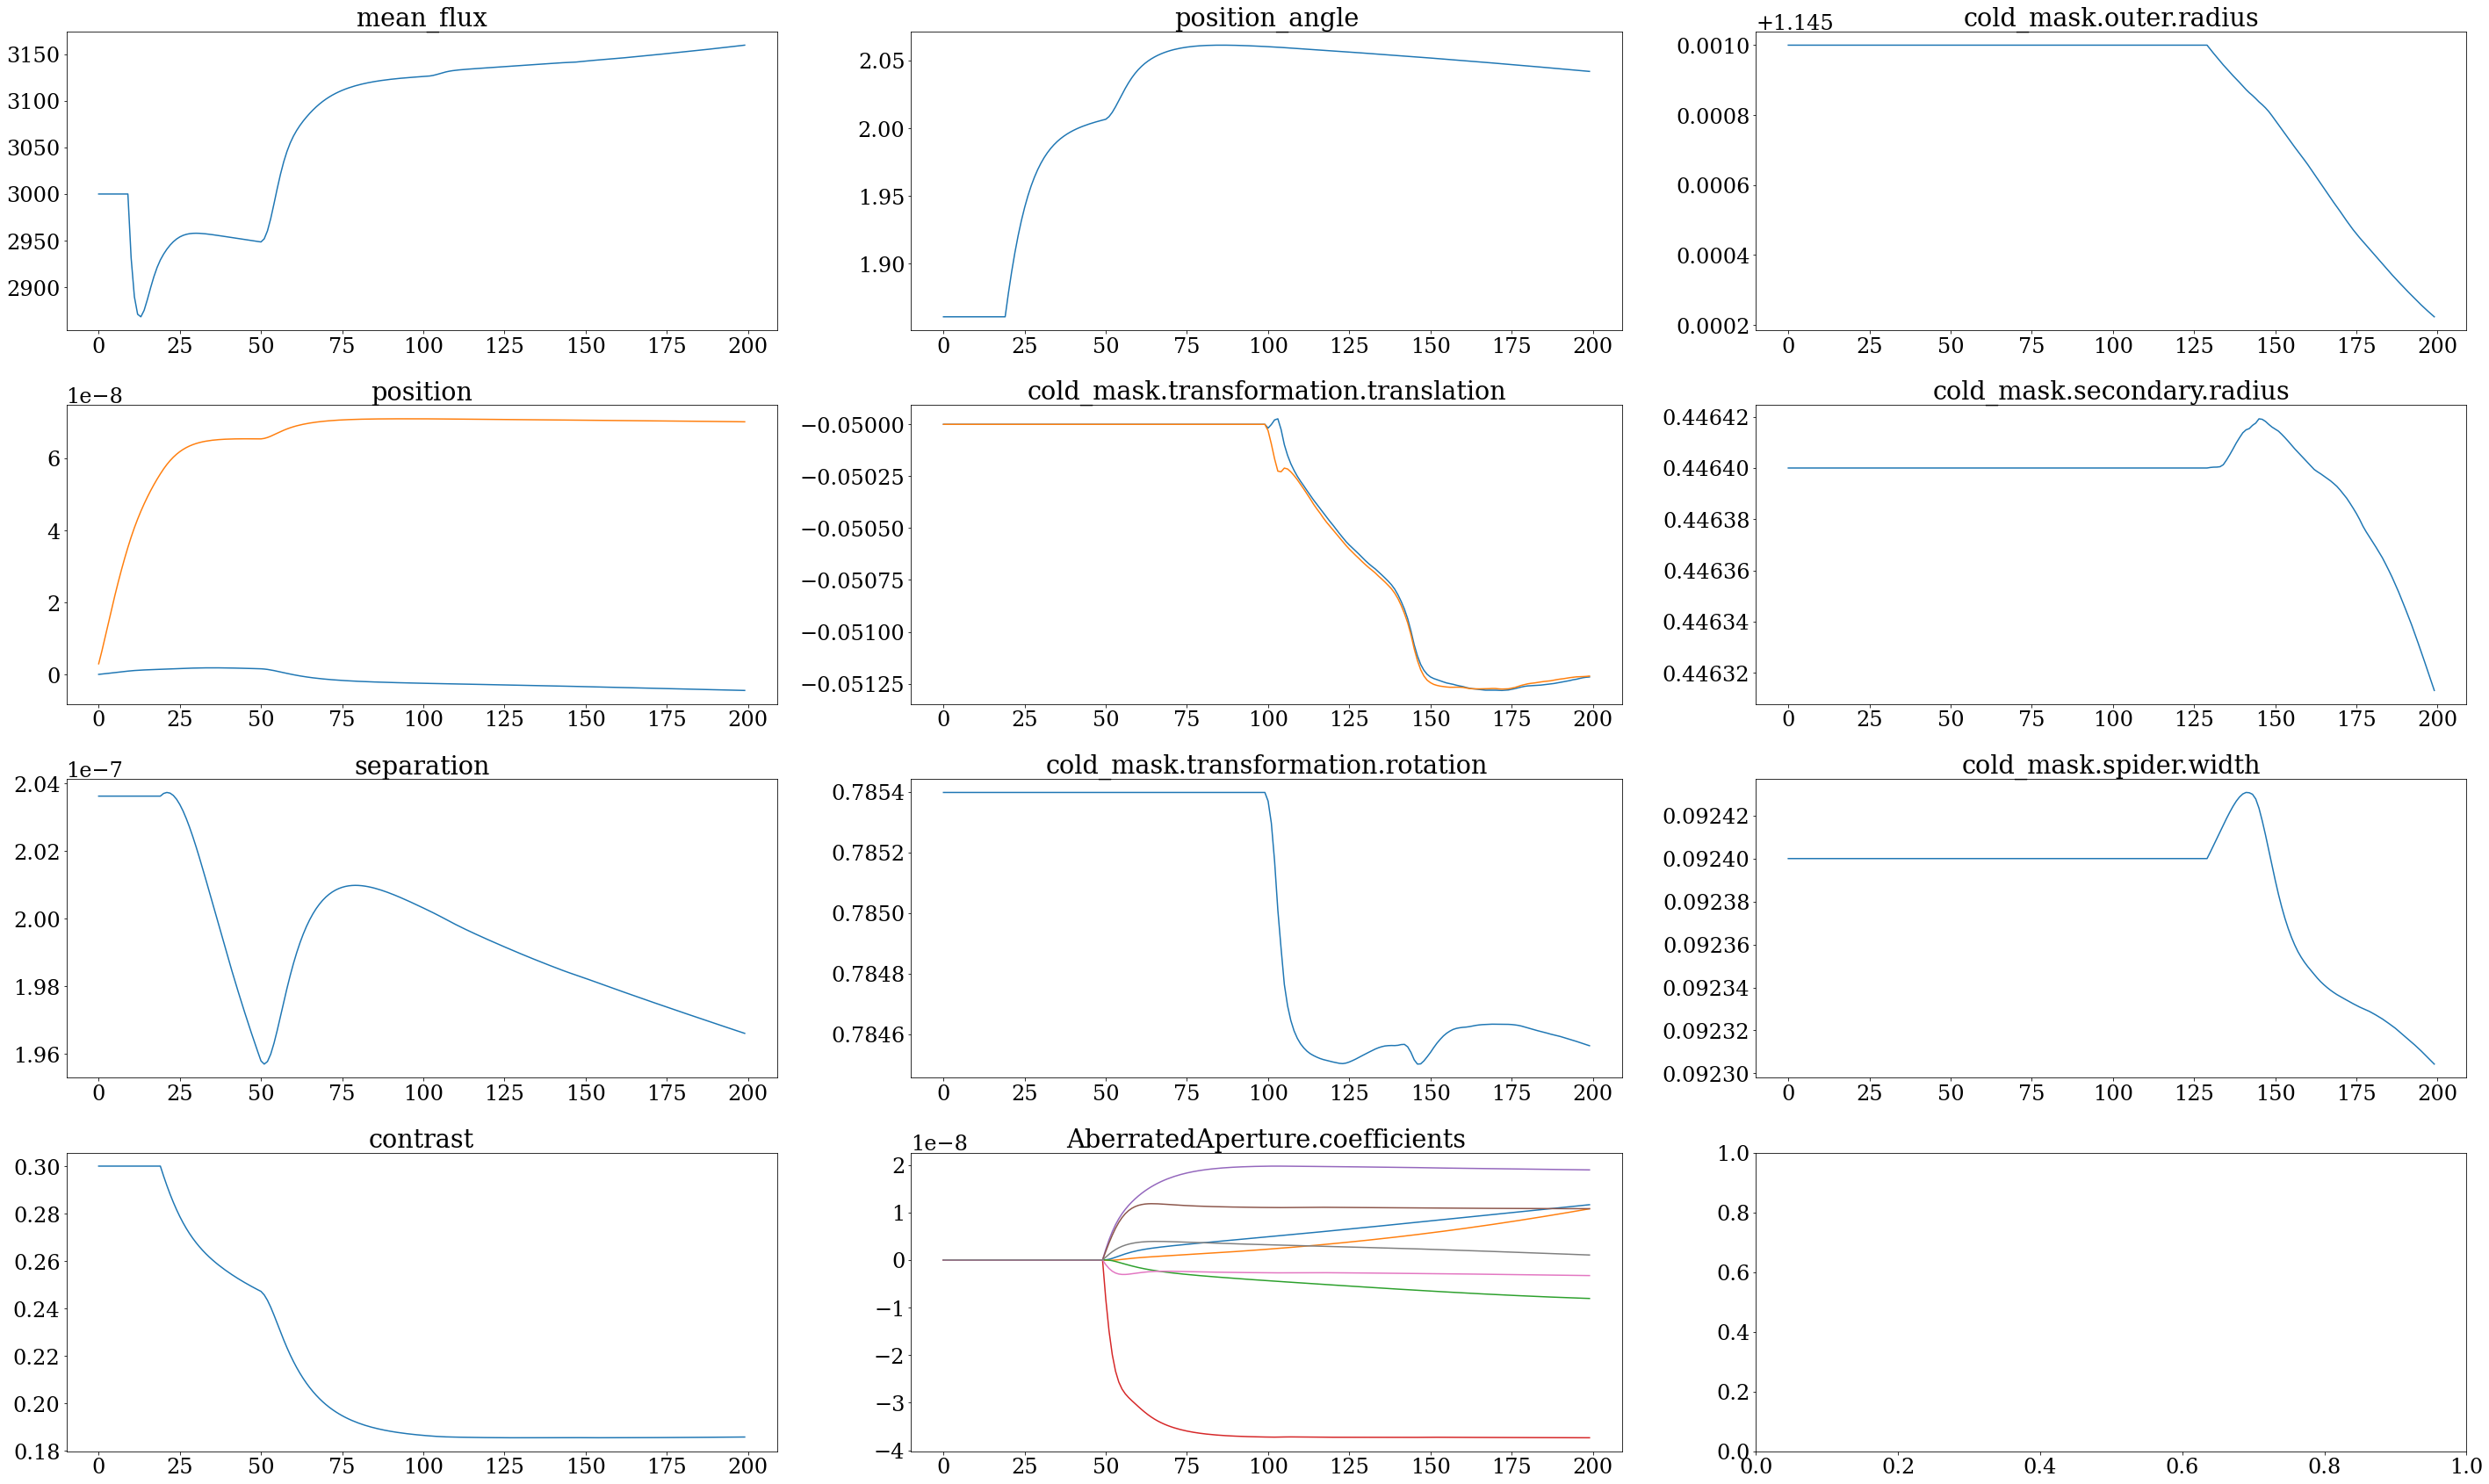

In [ ]:
#plt.plot([x.get("cold_mask.transformation.translation")[0] for x in models])

xw = 4
yw = int(np.ceil(len(groups)/xw))

print(len(groups))

fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups):
    print(param)
    sp = axs[i%xw, i//xw]
    if type(param) == list:
        sp.set_title(f"{param[0]} ...")
        for p in param:
            sp.plot([x.get(p) for x in models])
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models])
    
fig.tight_layout()

(Array(31, dtype=int32), Array(30, dtype=int32))

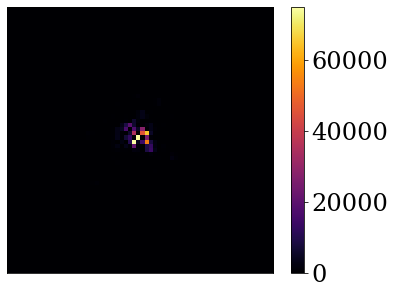

In [ ]:
cmap = matplotlib.colormaps['inferno']
#cmap.set_bad('k',1)
lpdf = -jsp.stats.norm.logpdf(telescope.model(), exposure.data, exposure.err)
plt.imshow(lpdf, cmap)
plt.colorbar()
plt.xticks([])
plt.yticks([])
np.unravel_index(np.nanargmax(lpdf),lpdf.shape)